In [ ]:
# multigrid_gnn_multires_physics.py
"""
Physics-informed Multigrid + GNN eigen-refinement
- Exact solve only on coarsest mesh
- Multiresolution GNN with residual + orthonormality + projection loss
- Coarse-to-fine prolongation only
"""

import os
import numpy as np
from scipy.linalg import eigh
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import eigsh
from sklearn.neighbors import NearestNeighbors

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

from Mesh import Mesh
import robust_laplacian

# ------------------------
# Utilities
# ------------------------
def sp_to_torch_sparse(A):
    A = A.tocoo()
    indices = np.vstack((A.row, A.col)).astype(np.int64)
    i = torch.LongTensor(indices)
    v = torch.FloatTensor(A.data)
    return torch.sparse_coo_tensor(i, v, A.shape).coalesce()

def normalize_columns_np(U, eps=1e-12):
    norms = np.linalg.norm(U, axis=0) + eps
    return U / norms, norms

def normalize_columns_torch(U, eps=1e-12):
    norms = torch.norm(U, dim=0) + eps
    return U / norms, norms

def farthest_point_sampling(points, n_samples, seed=None):
    """
    Farthest Point Sampling (FPS) for nested hierarchical sampling.
    
    Args:
        points: (N, 3) array of 3D points
        n_samples: number of points to sample
        seed: random seed for initial point selection
    
    Returns:
        indices: (n_samples,) array of selected point indices
    """
    n_points = points.shape[0]
    if n_samples >= n_points:
        return np.arange(n_points)
    
    rng = np.random.default_rng(seed=seed)
    
    # Start with a random point
    selected_indices = [rng.integers(0, n_points)]
    distances = np.full(n_points, np.inf)
    
    for _ in range(n_samples - 1):
        # Update distances to nearest selected point
        last_selected = selected_indices[-1]
        dists_to_last = np.linalg.norm(points - points[last_selected], axis=1)
        distances = np.minimum(distances, dists_to_last)
        
        # Select point farthest from all selected points
        farthest_idx = np.argmax(distances)
        selected_indices.append(farthest_idx)
    
    return np.array(selected_indices)

def voxel_downsampling_OLD(points, hierarchy_levels):
    """
    Voxel grid downsampling for nested hierarchical sampling.
    
    Args:
        points: (N, 3) array of 3D points
        hierarchy_levels: list of target point counts for each level
    
    Returns:
        indices_per_level: dict mapping level index to array of selected point indices
    """
    n_points = points.shape[0]
    
    # Compute bounding box
    min_bound = points.min(axis=0)
    max_bound = points.max(axis=0)
    extent = max_bound - min_bound
    
    indices_per_level = {}
    
    for level_idx, target_count in enumerate(hierarchy_levels):

        if target_count >= n_points:
            indices_per_level[level_idx] = np.arange(n_points)
            continue
        
        # Estimate voxel size based on target count
        # Volume per voxel ≈ total_volume / target_count
        volume = np.prod(extent)
        voxel_volume = volume / target_count
        voxel_size = voxel_volume ** (1/3)
        
        # Compute voxel grid dimensions
        grid_dims = np.ceil(extent / voxel_size).astype(int) + 1
        
        # Assign each point to a voxel
        voxel_indices = ((points - min_bound) / voxel_size).astype(int)
        voxel_indices = np.clip(voxel_indices, 0, grid_dims - 1)
        
        # Flatten voxel indices to 1D
        voxel_ids = (voxel_indices[:, 0] * grid_dims[1] * grid_dims[2] + 
                     voxel_indices[:, 1] * grid_dims[2] + 
                     voxel_indices[:, 2])
        
        # Select one point per occupied voxel (closest to voxel center)
        unique_voxels = np.unique(voxel_ids)
        selected_indices = []
        
        for voxel_id in unique_voxels:
            mask = (voxel_ids == voxel_id)
            voxel_points_idx = np.where(mask)[0]
            
            if len(voxel_points_idx) == 0:
                continue
            
            # Compute voxel center
            voxel_3d = np.array([
                voxel_id // (grid_dims[1] * grid_dims[2]),
                (voxel_id // grid_dims[2]) % grid_dims[1],
                voxel_id % grid_dims[2]
            ])
            voxel_center = min_bound + (voxel_3d + 0.5) * voxel_size
            
            # Find point closest to voxel center
            voxel_points = points[voxel_points_idx]
            distances = np.linalg.norm(voxel_points - voxel_center, axis=1)
            closest_idx = voxel_points_idx[np.argmin(distances)]
            selected_indices.append(closest_idx)
            
            # Stop if we've reached target count
            if len(selected_indices) >= target_count:
                break
        
        indices_per_level[level_idx] = np.array(selected_indices[:target_count])
    
    return indices_per_level


def voxel_downsampling(points, hierarchy_levels):
    """
    Voxel grid downsampling for nested hierarchical sampling.
    Args:
        points: (N, 3) array of 3D points
        hierarchy_levels: list of target point counts for each level
    Returns:
        indices_per_level: dict mapping level index to array of selected point indices
    """
    n_points = points.shape[0]
    min_bound = points.min(axis=0)
    max_bound = points.max(axis=0)
    extent = max_bound - min_bound
    
    indices_per_level = {}
    
    for level_idx, target_count in enumerate(hierarchy_levels):
        if target_count >= n_points:
            indices_per_level[level_idx] = np.arange(n_points)
            continue
        
        # Iteratively adjust voxel size to hit target
        # Start with a conservative estimate (assuming ~50% occupancy)
        volume = np.prod(extent)
        voxel_size = (volume / (target_count * 2)) ** (1/3)
        
        best_indices = None
        best_diff = float('inf')
        
        # Try multiple voxel sizes to get close to target
        for scale in [0.7, 0.85, 1.0, 1.15, 1.3, 1.5]:
            current_voxel_size = voxel_size * scale
            
            # Compute voxel grid
            grid_dims = np.ceil(extent / current_voxel_size).astype(int) + 1
            voxel_indices = ((points - min_bound) / current_voxel_size).astype(int)
            voxel_indices = np.clip(voxel_indices, 0, grid_dims - 1)
            
            # Flatten to 1D
            voxel_ids = (voxel_indices[:, 0] * grid_dims[1] * grid_dims[2] + 
                        voxel_indices[:, 1] * grid_dims[2] + 
                        voxel_indices[:, 2])
            
            # Select one point per voxel (closest to center)
            unique_voxels = np.unique(voxel_ids)
            selected_indices = []
            
            for voxel_id in unique_voxels:
                mask = (voxel_ids == voxel_id)
                voxel_points_idx = np.where(mask)[0]
                
                # Compute voxel center
                voxel_3d = np.array([
                    voxel_id // (grid_dims[1] * grid_dims[2]),
                    (voxel_id // grid_dims[2]) % grid_dims[1],
                    voxel_id % grid_dims[2]
                ])
                voxel_center = min_bound + (voxel_3d + 0.5) * current_voxel_size
                
                # Find closest point to center
                voxel_points = points[voxel_points_idx]
                distances = np.linalg.norm(voxel_points - voxel_center, axis=1)
                closest_idx = voxel_points_idx[np.argmin(distances)]
                selected_indices.append(closest_idx)
            
            # Check if this is closer to target
            diff = abs(len(selected_indices) - target_count)
            if diff < best_diff:
                best_diff = diff
                best_indices = np.array(selected_indices)
            
            # If we're very close or over target, we can stop
            if len(selected_indices) >= target_count * 0.95:
                break
        
        indices_per_level[level_idx] = best_indices[:target_count] if len(best_indices) > target_count else best_indices
    
    return indices_per_level

# ------------------------
# Simple neighbor-mean corrector
# ------------------------
class SimpleCorrector(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_sizes=(128,128,128), dropout=0.0):
        super().__init__()
        layers = []
        prev = in_dim * 2
        for h in hidden_sizes:
            layers.append(nn.Linear(prev, h))
            layers.append(nn.ReLU(inplace=True))
            if dropout > 0.0:
                layers.append(nn.Dropout(dropout))
            prev = h
        layers.append(nn.Linear(prev, out_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x, edge_index):
        row, col = edge_index
        n = x.shape[0]
        agg = torch.zeros_like(x)
        agg.index_add_(0, row, x[col])
        deg = torch.bincount(row, minlength=n).unsqueeze(1).to(x.dtype).to(x.device).clamp(min=1.0)
        agg = agg / deg
        h = torch.cat([x, agg], dim=1)
        return self.net(h)

# ------------------------
# Multigrid GNN solver
# ------------------------
class MultigridGNN:
    def __init__(self, device=None, checkpoint_dir="./checkpoints"):
        self.device = device or (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
        self.model = None
        self.checkpoint_dir = checkpoint_dir
        os.makedirs(self.checkpoint_dir, exist_ok=True)

    @staticmethod
    def normalize_mesh(mesh):
        centroid = mesh.verts.mean(0)
        std_max = mesh.verts.std(0).max() + 1e-12
        verts_normalized = (mesh.verts - centroid) / std_max
        return Mesh(verts=verts_normalized, connectivity=mesh.connectivity)

    @staticmethod
    def build_prolongation(X_coarse, X_fine, k=1):
        nbrs = NearestNeighbors(n_neighbors=k, algorithm='auto').fit(X_coarse)
        distances, indices = nbrs.kneighbors(X_fine)
        n_fine, n_coarse = X_fine.shape[0], X_coarse.shape[0]
        rows, cols, vals = [], [], []
        for i in range(n_fine):
            weights = 1.0 / (distances[i] + 1e-12)
            weights /= weights.sum()
            for j, idx in enumerate(indices[i]):
                rows.append(i)
                cols.append(idx)
                vals.append(weights[j])
        return coo_matrix((vals, (rows, cols)), shape=(n_fine, n_coarse))

    @staticmethod
    def build_knn_graph(X, k=4):
        n_points = X.shape[0]
        nbrs = NearestNeighbors(n_neighbors=k+1).fit(X)
        _, neighbors = nbrs.kneighbors(X)
        rows, cols = [], []
        for i in range(n_points):
            for j in neighbors[i][1:]:
                rows.append(i)
                cols.append(j)
        return torch.LongTensor([rows, cols]).to(torch.long)

    def solve_eigenvalue_problem(self, X, n_modes):
        L, M = robust_laplacian.point_cloud_laplacian(X)
        vals, vecs = eigsh(L, k=n_modes, M=M, which='SM')
        return vals, np.array(vecs), L, M

    # ------------------------
    # Physics-informed GNN training
    # ------------------------
    def train_multiresolution_OLD(self, X_list, U_init_list, edge_index_list,
                              epochs=1000, lr=1e-3, corr_scale=1e-1,
                              w_res=5.0, w_orth=10.0, w_proj=1.0,
                              grad_clip=1.0, weight_decay=1e-6, log_every=250):
        device = self.device
        n_modes = U_init_list[0].shape[1]

        # Build torch tensors and resolution indicators
        x_feats_all, U_all, edge_index_all = [], [], []
        node_offset = 0
        max_nodes = max([X.shape[0] for X in X_list])
        for X, U_init, edge_index in zip(X_list, U_init_list, edge_index_list):
            res_feat = np.full((X.shape[0], 1), X.shape[0]/max_nodes)
            x_feats_all.append(np.hstack([X, U_init, res_feat]))
            U_all.append(U_init)
            edge_index_all.append(edge_index + node_offset)
            node_offset += X.shape[0]

        x_feats_all = torch.FloatTensor(np.vstack(x_feats_all)).to(device)
        U_all_tensor = torch.FloatTensor(np.vstack(U_all)).to(device)
        edge_index_all = torch.cat(edge_index_all, dim=1).to(device)

        in_dim = x_feats_all.shape[1]
        if self.model is None:
            self.model = SimpleCorrector(in_dim, n_modes).to(device)

        optimizer = optim.Adam(filter(lambda p: p.requires_grad, self.model.parameters()), lr=lr, weight_decay=weight_decay)
        self.model.train()

        # ------------------------
        # Precompute Laplacians per level
        L_list, M_list = [], []
        node_offset = 0
        for X in X_list:
            L, M = robust_laplacian.point_cloud_laplacian(X)
            L_list.append(sp_to_torch_sparse(L).to(device))
            M_list.append(sp_to_torch_sparse(M).to(device))

        for ep in range(epochs):
            optimizer.zero_grad()
            corr_raw = self.model(x_feats_all, edge_index_all)
            corr = corr_scale * corr_raw
            U_pred = U_all_tensor + corr

            # Physics-informed loss
            loss = 0.0
            node_offset = 0
            L_res_total = 0.0
            L_orth_total = 0.0
            L_mean_total = 0.0
            
            for i, (L_t, M_t, U_init) in enumerate(zip(L_list, M_list, U_init_list)):
                n_nodes = U_init.shape[0]
                U_level = U_pred[node_offset:node_offset+n_nodes]

                # Rayleigh residual
                Lu = torch.sparse.mm(L_t, U_level)
                Mu = torch.sparse.mm(M_t, U_level)
                num = torch.sum(U_level * Lu, dim=0)
                den = torch.sum(U_level * Mu, dim=0) + 1e-12
                lambdas = num / den
                res = Lu - Mu * lambdas.unsqueeze(0)
                L_res = torch.mean(res**2)
                
                # Orthonormality
                Gram = U_level.t() @ Mu
                L_orth = torch.mean((Gram - torch.eye(n_modes, device=device))**2)

                # Zero-mean constraint: 1.T @ M @ u = 0 for modes 1 onwards
                ones = torch.ones(n_nodes, 1, device=device)
                mean_constraint = ones.t() @ Mu[:, 1:]  # Shape: (1, n_modes-1)
                L_mean = torch.mean(mean_constraint**2)

                loss += w_res * L_res + w_orth * L_orth + w_proj * L_mean
                node_offset += n_nodes

            loss.backward()
            if grad_clip is not None:
                torch.nn.utils.clip_grad_norm_(filter(lambda p: p.requires_grad, self.model.parameters()), grad_clip)
            optimizer.step()

            if ep % log_every == 0 or ep == epochs-1:
                print(f"Epoch {ep:4d}: Loss={loss.item():.6f} | Res={L_res.item():.6f} | Orth={L_orth.item():.6f} | Mean={L_mean.item():.6f}")

        return U_pred.detach().cpu().numpy()


    def train_multiresolution(self, X_list, U_init_list, edge_index_list,
                            epochs=1000, lr=1e-3, corr_scale=1e-1,
                            w_res=5.0, w_orth=10.0, w_proj=0.001,
                            grad_clip=1.0, weight_decay=1e-6, log_every=250):
        device = self.device
        n_modes = U_init_list[0].shape[1]

        # Build torch tensors and resolution indicators
        x_feats_all, U_all, edge_index_all = [], [], []
        node_offset = 0
        max_nodes = max([X.shape[0] for X in X_list])
        for X, U_init, edge_index in zip(X_list, U_init_list, edge_index_list):
            res_feat = np.full((X.shape[0], 1), X.shape[0]/max_nodes)
            x_feats_all.append(np.hstack([X, U_init, res_feat]))
            U_all.append(U_init)
            edge_index_all.append(edge_index + node_offset)
            node_offset += X.shape[0]

        x_feats_all = torch.FloatTensor(np.vstack(x_feats_all)).to(device)
        U_all_tensor = torch.FloatTensor(np.vstack(U_all)).to(device)
        edge_index_all = torch.cat(edge_index_all, dim=1).to(device)

        in_dim = x_feats_all.shape[1]
        if self.model is None:
            self.model = SimpleCorrector(in_dim, n_modes).to(device)

        optimizer = optim.Adam(filter(lambda p: p.requires_grad, self.model.parameters()), 
                            lr=lr, weight_decay=weight_decay)
        self.model.train()

        # Precompute Laplacians per level
        L_list, M_list = [], []
        node_offset = 0
        for X in X_list:
            L, M = robust_laplacian.point_cloud_laplacian(X)
            L_list.append(sp_to_torch_sparse(L).to(device))
            M_list.append(sp_to_torch_sparse(M).to(device))

        for ep in range(epochs):
            optimizer.zero_grad()
            corr_raw = self.model(x_feats_all, edge_index_all)
            corr = corr_scale * corr_raw
            U_pred = U_all_tensor + corr

            # Physics-informed loss
            loss = 0.0
            node_offset = 0
            
            for i, (L_t, M_t, U_init) in enumerate(zip(L_list, M_list, U_init_list)):
                n_nodes = U_init.shape[0]
                U_level = U_pred[node_offset:node_offset+n_nodes]
                
                # === CRITICAL FIX: Normalize each eigenvector ===
                Mu = torch.sparse.mm(M_t, U_level)
                norms = torch.sqrt(torch.sum(U_level * Mu, dim=0) + 1e-12)
                U_level_normalized = U_level / norms.unsqueeze(0)
                
                # Recompute with normalized vectors
                Mu_norm = torch.sparse.mm(M_t, U_level_normalized)
                Lu_norm = torch.sparse.mm(L_t, U_level_normalized)

                # Rayleigh residual
                num = torch.sum(U_level_normalized * Lu_norm, dim=0)
                den = torch.sum(U_level_normalized * Mu_norm, dim=0) + 1e-12
                lambdas = num / den
                res = Lu_norm - Mu_norm * lambdas.unsqueeze(0)
                L_res = torch.mean(res**2)
                
                # Orthonormality (should be near-perfect with normalization)
                Gram = U_level_normalized.t() @ Mu_norm
                L_orth = torch.mean((Gram - torch.eye(n_modes, device=device))**2)

                # === CRITICAL FIX: Zero-mean constraint for modes 1+ (NOT mode 0) ===
                # Mode 0 is constant, modes 1+ should be zero-mean
                ones = torch.ones(n_nodes, 1, device=device)
                if n_modes > 1:
                    # Project out constant component from modes 1 onwards
                    mean_constraint = ones.t() @ Mu_norm[:, 1:]  # Shape: (1, n_modes-1)
                    L_mean = torch.mean(mean_constraint**2)
                else:
                    L_mean = torch.tensor(0.0, device=device)

                loss += w_res * L_res + w_orth * L_orth + w_proj * L_mean
                node_offset += n_nodes

            loss.backward()
            if grad_clip is not None:
                torch.nn.utils.clip_grad_norm_(filter(lambda p: p.requires_grad, 
                                                    self.model.parameters()), grad_clip)
            optimizer.step()

            if ep % log_every == 0 or ep == epochs-1:
                print(f"Epoch {ep:4d}: Loss={loss.item():.6f} | "
                    f"Res={L_res.item():.6f} | Orth={L_orth.item():.6f} | "
                    f"Mean={L_mean.item():.6f}")

        # === POST-TRAINING: Final normalization ===
        with torch.no_grad():
            corr_raw = self.model(x_feats_all, edge_index_all)
            corr = corr_scale * corr_raw
            U_pred = U_all_tensor + corr
            
            # Normalize per level
            node_offset = 0
            U_pred_normalized = []
            for i, M_t in enumerate(M_list):
                n_nodes = U_init_list[i].shape[0]
                U_level = U_pred[node_offset:node_offset+n_nodes]
                
                Mu = torch.sparse.mm(M_t, U_level)
                norms = torch.sqrt(torch.sum(U_level * Mu, dim=0) + 1e-12)
                U_level_norm = U_level / norms.unsqueeze(0)
                U_pred_normalized.append(U_level_norm)
                
                node_offset += n_nodes
            
            U_pred_final = torch.cat(U_pred_normalized, dim=0)

        return U_pred_final.detach().cpu().numpy()

    # ------------------------
    # Rayleigh-Ritz refinement
    # ------------------------
    def refine_eigenvectors(self, U_pred, L, M):
        U = torch.FloatTensor(U_pred).to(self.device)
        L_t = sp_to_torch_sparse(L).to(self.device)
        M_t = sp_to_torch_sparse(M).to(self.device)
        A = (U.t() @ torch.sparse.mm(L_t, U)).cpu().numpy()
        B = (U.t() @ torch.sparse.mm(M_t, U)).cpu().numpy()
        vals, C = eigh(A, B)
        U_refined = U.cpu().numpy() @ C
        return vals, U_refined
        

def visualize_mesh(mesh, title='Mesh Visualization', highlight_indices=None):
    """Visualize mesh with vertices, optionally highlighting specific points."""
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(projection='3d')
    
    # Plot full mesh with transparency
    ax.plot_trisurf(mesh.verts[:, 0], mesh.verts[:, 1], mesh.verts[:, 2], 
                    triangles=mesh.connectivity, alpha=0.3)
    
    # Highlight specific points if provided
    if highlight_indices is not None:
        highlighted_verts = mesh.verts[highlight_indices]
        ax.scatter(highlighted_verts[:, 0], highlighted_verts[:, 1], highlighted_verts[:, 2], 
                   c='fuchsia', s=10, alpha=0.8, label=f'{len(highlight_indices)} selected points')
        ax.legend()
    
    ax.set_title(title)
    ax.view_init(elev=130, azim=-90)
    plt.show()


# ------------------------
# Main
# ------------------------
def main():
    mesh_path = "bunny.obj"
    n_modes = 128
    hierarchy = [256, 512, 1024]  # final level is full mesh
    k_neighbors = 4
    epochs = 10_000

    print("Loading mesh...")
    mesh = Mesh(mesh_path)
    mesh = MultigridGNN.normalize_mesh(mesh)
    X_full = mesh.verts
    n_total = X_full.shape[0]
    hierarchy = [n for n in hierarchy if n <= n_total]
    if hierarchy[-1] != n_total:
        hierarchy.append(n_total)
    print("Hierarchy:", hierarchy)

    # Use Voxel Grid Downsampling for nested hierarchy
    print("Computing voxel grid downsampling hierarchy...")
    indices_per_level = voxel_downsampling(X_full, hierarchy)
    
    for i, n_points in enumerate(hierarchy):
        actual_count = len(indices_per_level[i])
        print(f"  Level {i}: {actual_count} points (voxel downsampling, target: {n_points})")
    

    #for level_idx_vis, n_points in enumerate(hierarchy):
    #    # Visualize selected points for this level
    #    visualize_mesh(mesh, 
    #                  title=f'Level {level_idx_vis}: {len(indices_per_level[level_idx_vis])} Voxel Downsampled Points',
    #                  highlight_indices=indices_per_level[level_idx_vis])
    #print()

    solver = MultigridGNN()

    # ------------------------
    # Level 0: exact coarse solve
    # ------------------------
    idx0 = indices_per_level[0]
    X0 = X_full[idx0]
    print(f"\nLEVEL 0: exact solve on {X0.shape[0]} points...")
    lambda0, U0, L0, M0 = solver.solve_eigenvalue_problem(X0, n_modes)
    print("Coarse eigenvalues:", np.round(lambda0,6))

    # ------------------------
    # Coarse-to-fine prolongation
    # ------------------------
    U_prev = U0.copy()
    X_list, U_init_list, edge_index_list = [X0], [U0], [solver.build_knn_graph(X0, k=k_neighbors)]
    for level in range(1, len(hierarchy)):
        idx_coarse = indices_per_level[level-1]
        idx_fine = indices_per_level[level]
        Xc = X_full[idx_coarse]
        Xf = X_full[idx_fine]

        P = solver.build_prolongation(Xc, Xf, k=1)
        U_init = P @ U_prev
        edge_index = solver.build_knn_graph(Xf, k=k_neighbors)

        X_list.append(Xf)
        U_init_list.append(U_init)
        edge_index_list.append(edge_index)

        U_prev = U_init.copy()

    # ------------------------
    # Train physics-informed GNN
    # ------------------------
    print("\nTraining physics-informed multiresolution GNN...")
    U_pred_all = solver.train_multiresolution(X_list, U_init_list, edge_index_list,
                                              epochs=epochs)

    # ------------------------
    # Rayleigh-Ritz refinement per level
    # ------------------------
    node_offset = 0
    for level, X in enumerate(X_list):
        n_nodes = X.shape[0]
        U_pred = U_pred_all[node_offset:node_offset+n_nodes]
        node_offset += n_nodes
        L, M = robust_laplacian.point_cloud_laplacian(X)
        vals_refined, _ = solver.refine_eigenvectors(U_pred, L, M)
        print(f"Level {level} refined eigenvalues: {np.round(vals_refined,3)}")

    finest_idx = len(hierarchy) - 1
    node_offset = sum(X.shape[0] for X in X_list[:-1])
    U_finest = U_pred_all[node_offset:]

    X_finest = X_list[-1]
    L_finest, M_finest = robust_laplacian.point_cloud_laplacian(X_finest)

    # Check orthonormality
    tmp_mat = U_finest.T @ M_finest @ U_finest
    print("\nOrthonormality check (should be Identity):")
    print("Diagonal:", np.diag(tmp_mat)[:10])
    print("Off-diagonal max:", np.max(np.abs(tmp_mat - np.eye(n_modes))))

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(tmp_mat, cmap='magma', vmin=-0.1, vmax=1.1)
    plt.colorbar()
    plt.title('U^T M U (should be Identity)')
    plt.subplot(1, 2, 2)
    plt.imshow(np.abs(tmp_mat - np.eye(n_modes)), cmap='magma')
    plt.colorbar()
    plt.title('|U^T M U - I|')
    plt.show()

    return U_pred

Loading mesh...
Hierarchy: [256, 512, 1024, 2503]
Computing voxel grid downsampling hierarchy...
  Level 0: 256 points (voxel downsampling, target: 256)
  Level 1: 512 points (voxel downsampling, target: 512)
  Level 2: 1003 points (voxel downsampling, target: 1024)
  Level 3: 2503 points (voxel downsampling, target: 2503)

LEVEL 0: exact solve on 256 points...
Coarse eigenvalues: [ 0.        0.435665  1.101353  1.361641  2.24765   2.624986  2.966489
  3.271591  4.159112  4.861363  5.361066  6.297796  6.551009  7.535665
  7.830018  8.265498  8.558741  8.991973  9.5702   10.4285   11.676696
 11.946871 12.458151 12.724494 13.380103 13.981007 14.244296 14.638334
 15.218399 15.704105 16.254595 17.037909 17.495824 18.254192 18.323736
 18.881708 19.071994 19.308503 20.182206 20.377067 21.585959 21.704952
 21.772461 22.032299 22.209848 22.70086  23.066203 23.584519 23.990922
 24.076166 24.783897 25.275924 25.923941 26.193233 26.486029 27.088955
 27.452173 28.210039 28.383028 28.393381 28.6209

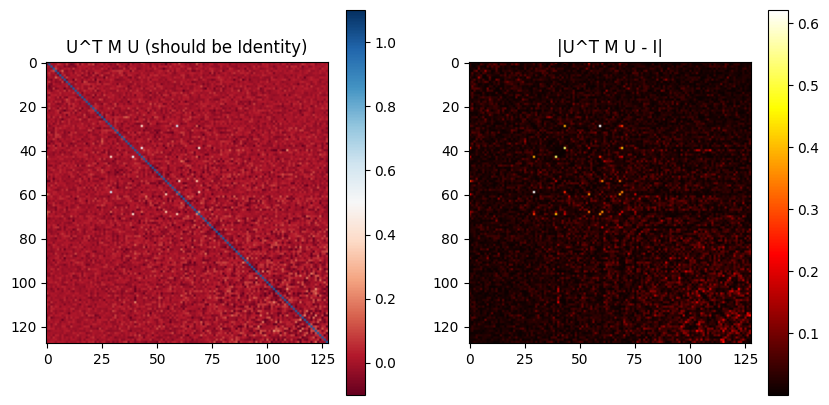

In [113]:
U_pred = main()

In [99]:
import meshio

m = Mesh('bunny.obj')

centroid = m.verts.mean(0)
std_max = m.verts.std(0).max()

verts_new = (m.verts - centroid)/std_max

m = Mesh(verts = verts_new, connectivity = m.connectivity)
cells = [('triangle', m.connectivity)]

m_out = meshio.Mesh(m.verts, cells, point_data={f'v{i}': U_pred[:, i] for i in range(0, 128)})
m_out.write('bunny_eigfuncs_voxel_downsampling.vtu')

In [81]:

print('Computing Laplacian')
K, M = m.computeLaplacian()
print('Computing eigen values')
eigvals, eigvecs = eigh(K,M)

Computing Laplacian
Computing eigen values


In [106]:
tmp_mat = U_pred.T @ M @ U_pred
tmp_ex  = eigvecs[:, :128].T @ M @ eigvecs[:, :128]

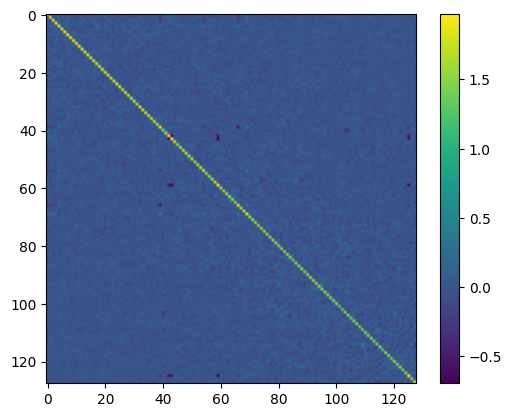

In [107]:
plt.imshow(tmp_mat)
plt.colorbar()

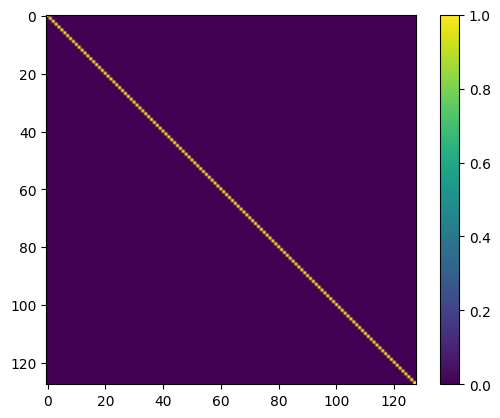

In [73]:
plt.imshow(tmp_ex)
plt.colorbar()

In [ ]:
"""
Questions
- How many stages of correction are needed
- How low can we go as starting point
- What is the topology of NN (architecture)
- Does Marching Cube sampling benefit --> check meshlab
"""

'\nQuestions\n- \nL_high = P @ L_low + correction\n'

In [57]:
tmp_mat

array([[ 1.88854825e+00,  3.94970717e-02,  3.65400551e-02, ...,
        -2.93498640e-02,  4.31970407e-02,  5.15070935e-03],
       [ 3.94970717e-02,  1.72678145e+00, -4.46355724e-02, ...,
        -1.68308391e-03,  4.01227860e-02, -1.61240212e-04],
       [ 3.65400551e-02, -4.46355724e-02,  1.50461670e+00, ...,
         1.42552165e-02, -5.50077163e-02, -1.97289970e-02],
       ...,
       [-2.93498640e-02, -1.68308391e-03,  1.42552165e-02, ...,
         9.91664124e-02, -3.90360189e-03,  2.07691846e-02],
       [ 4.31970407e-02,  4.01227860e-02, -5.50077163e-02, ...,
        -3.90360189e-03,  6.15139446e-02, -8.93604402e-03],
       [ 5.15070935e-03, -1.61240212e-04, -1.97289970e-02, ...,
         2.07691846e-02, -8.93604402e-03,  4.47512771e-02]],
      shape=(120, 120))